# Bis438 Final Project Problem 2

## Import Python Libraries

In [1]:
import tensorflow as tf
import numpy as np
import deepchem as dc

from model import GCN, MLP
from utils import process_prediction, make_feature, split_data

/home/baseline/.conda/envs/test/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Build GraphConv Model

In [2]:
batch_size = 50
gcn_model = GCN(batch_size=batch_size) # build model

## Training GraphConv Model and Calculate ROC-AUC

In [3]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification") # define metric as roc_auc_score

num_models = 10 # the number of iteration
rocauc_train = [] # save rocauc value for training dataset
rocauc_valid = [] # save rocauc value for validation dataset
rocauc_test = [] # save rocauc value for test dataset

# Do featurization
conv_feature = make_feature('BACE','GraphConv')

for i in range(num_models):
    # Load ith dataset with GraphConv Featurizer and random split
    train_dataset, valid_dataset, test_dataset = split_data(conv_feature)
    
    # Fitting ith model with training dataset
    gcn_model.fit(train_dataset, 3) # fitting with training epoch 3
    
    # Evaluating model   
    # save rocauc for training dataset
    pred_train = gcn_model.predict(train_dataset)
    pred_train = process_prediction(train_dataset.y, pred_train)
    train_scores = metric.compute_metric(train_dataset.y, pred_train, train_dataset.w)
    rocauc_train.append(train_scores)

    # save rocauc for valid dataset
    pred_valid = gcn_model.predict(valid_dataset)
    pred_valid = process_prediction(valid_dataset.y, pred_valid)
    valid_scores = metric.compute_metric(valid_dataset.y, pred_valid, valid_dataset.w)
    rocauc_valid.append(valid_scores)
   
    # save rocauc for test dataset
    pred_test = gcn_model.predict(test_dataset)
    pred_test = process_prediction(test_dataset.y, pred_test)
    test_scores = metric.compute_metric(test_dataset.y, pred_test, test_dataset.w)
    rocauc_test.append(test_scores)   
    
    # print rocauc result
    print("Evaluating model number ", i)
    print("Train ROC-AUC Score: " , train_scores,  
          "Valid ROC-AUC Score: " , valid_scores,
          "Test ROC-AUC Score: " , test_scores)         

Loading raw samples now.
shard_size: 8192
About to start loading CSV from ../data/bace.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 3.200 s
TIMING: dataset construction took 3.855 s
Loading dataset from disk.
TIMING: dataset construction took 0.852 s
Loading dataset from disk.
TIMING: dataset construction took 0.590 s
Loading dataset from disk.
TIMING: dataset construction took 0.391 s
Loading dataset from disk.
TIMING: dataset construction took 0.224 s
Loading dataset from disk.


/home/baseline/.conda/envs/test/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.766854264669898]
computed_metrics: [0.7067781690140845]
computed_metrics: [0.6871767433565186]
Evaluating model number  0
Train ROC-AUC Score:  0.766854264669898 Valid ROC-AUC Score:  0.7067781690140845 Test ROC-AUC Score:  0.6871767433565186
TIMING: dataset construction took 0.797 s
Loading dataset from disk.
TIMING: dataset construction took 0.230 s
Loading dataset from disk.
TIMING: dataset construction took 0.228 s
Loading dataset from disk.
computed_metrics: [0.847878412763909]
computed_metrics: [0.8579382183908046]
computed_metrics: [0.8315972222222222]
Evaluating model number  1
Train ROC-AUC Score:  0.847878412763909 Valid ROC-AUC Score:  0.8579382183908046 Test ROC-AUC Score:  0.8315972222222222
TIMING: dataset construction took 0.778 s
Loading dataset from disk.
TIMING: dataset construction took 0.233 s
Loading dataset from disk.
TIMING: dataset construction took 0.231 s
Loading dataset from disk.
computed_metrics: [0.8731101928374656]
computed_metrics: [

## Calculate mean value of ROC-AUC and use std1 for error bar in GCN model

In [4]:
gcn_values = []
gcn_values.append(np.mean(rocauc_train))
gcn_values.append(np.mean(rocauc_valid))
gcn_values.append(np.mean(rocauc_test))
gcn_stds = []
gcn_stds.append(np.std(rocauc_train))
gcn_stds.append(np.std(rocauc_valid))
gcn_stds.append(np.std(rocauc_test))

## Build Multi Layer Perceptron using keras

In [5]:
from model import MLP
batch_size = 50
dense_model = MLP(batch_size=batch_size)

## Training Multi Layer Percpetron Model and Calculate ROC-AUC

In [6]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification") # define metric as roc_auc_score

num_models = 10 # the number of iteration
rocauc_train = [] # save rocauc value for training dataset
rocauc_valid = [] # save rocauc value for validation dataset
rocauc_test = [] # save rocauc value for test dataset

# Do featurization
ecfp_feature = make_feature('BACE','ECFP')

for i in range(num_models):
    # Load ith dataset with GraphConv Featurizer and random split
    train_dataset, valid_dataset, test_dataset = split_data(ecfp_feature)
    
    # Fitting ith model with training dataset
    dense_model.fit(train_dataset, 3) # fitting with training epoch 3
    
    # Evaluating model   
    # save rocauc for training dataset
    pred_train = dense_model.predict(train_dataset)
    pred_train = process_prediction(train_dataset.y, pred_train)
    train_scores = metric.compute_metric(train_dataset.y, pred_train)
    rocauc_train.append(train_scores)

    # save rocauc for valid dataset
    pred_valid = dense_model.predict(valid_dataset)
    pred_valid = process_prediction(valid_dataset.y, pred_valid)
    valid_scores = metric.compute_metric(valid_dataset.y, pred_valid)
    rocauc_valid.append(valid_scores)
   
    # save rocauc for test dataset
    pred_test = dense_model.predict(test_dataset)
    pred_test = process_prediction(test_dataset.y, pred_test)
    test_scores = metric.compute_metric(test_dataset.y, pred_test)
    rocauc_test.append(test_scores)   
    
    # print rocauc result
    print("Evaluating model number ", i)
    print("Train ROC-AUC Score: " , train_scores,  
          "Valid ROC-AUC Score: " , valid_scores,
          "Test ROC-AUC Score: " , test_scores)   

Loading raw samples now.
shard_size: 8192
About to start loading CSV from ../data/bace.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 2.760 s
TIMING: dataset construction took 2.902 s
Loading dataset from disk.
TIMING: dataset construction took 0.056 s
Loading dataset from disk.
TIMING: dataset construction took 0.051 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
computed_metrics: [0.9198265596401085]
computed_metrics: [0.8597625797306875]
computed_metrics: [0.8244155844155845]
Evaluating model number  0
Train ROC-AUC Score:  0.9198265596401085 Valid ROC-AUC Score:  0.8597625797306875 Test ROC-AUC Score:  0.8244155844155845
TIMING: dataset construction took 0.065 s
Loading dataset from disk.
TIMING: dataset construction took 0.026 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Lo

## Calculate mean value of ROC-AUC and use std1 for error bar in MLP model

In [7]:
mlp_values = []
mlp_values.append(np.mean(rocauc_train))
mlp_values.append(np.mean(rocauc_valid))
mlp_values.append(np.mean(rocauc_test))
mlp_stds = []
mlp_stds.append(np.std(rocauc_train))
mlp_stds.append(np.std(rocauc_valid))
mlp_stds.append(np.std(rocauc_test))

## Plot ROC-AUC Score

NameError: name 'p1' is not defined

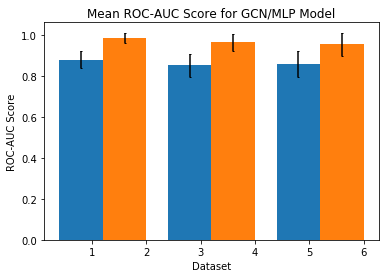

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

topics = ['train', 'valid', 'test']

def create_x(t, w, n, d):
    return [t*x + w*n for x in range(d)]

gcn_values_x = create_x(2, 0.8, 1, 3)
mlp_values_x = create_x(2, 0.8, 2, 3)

ax = plt.subplot()
p1 = ax.bar(gcn_values_x, gcn_values, yerr=gcn_stds, capsize=1)
p2 = ax.bar(mlp_values_x, mlp_values, yerr=mlp_stds, capsize=1)

middle_x = [(a+b)/2 for (a,b) in zip(gcn_values_x, mlp_values_x)]

ax.set_title('Mean ROC-AUC Score for GCN/MLP Model')
ax.set_xlabel('Dataset')
ax.set_ylabel('ROC-AUC Score')
ax.legend((p1[0], p2[0]), ('GCN', 'MLP'), fontsize=15)
ax.set_xticks(middle_x)
ax.set_xticklabels(topics)
plt.show()